In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib
import umap
import matplotlib.gridspec as gridspec
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 11

In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [3]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, steps))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, steps))

correlation = []

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            for i in range(tc_rates.shape[0]):
                correlation.append(np.corrcoef(tc_rates[i,0,:], tc_FF[i,0,:])[0,1])
            
            # first covariate is head direction, take the entire tuning curve on head direction
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = tc_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = tc_rates.shape[0]
            
            features_rates = np.concatenate((features_rates, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            features_FF = np.concatenate((features_FF, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)

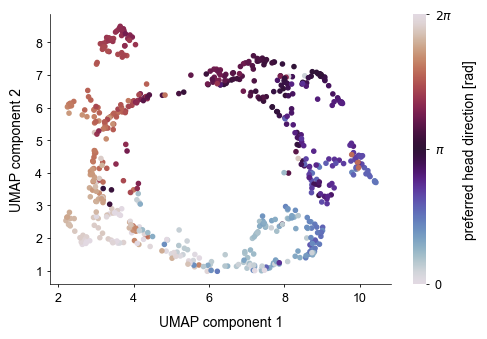

In [15]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.05 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates)

fig, ax = plt.subplots(figsize=(5.5,3.5))

max_index = np.argmax(features_rates, axis=1)
angles = np.linspace(0, 2*np.pi, features_rates.shape[1])
tuned_angle = [angles[i] for i in max_index]
p = ax.scatter(embedding_rates[:,0], embedding_rates[:, 1], c = tuned_angle, cmap = 'twilight')
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')

cb = fig.colorbar(p)
cb.outline.set_visible(False)
cb.set_label('preferred head direction [rad]')
cb.set_ticks([0, np.pi, 2*np.pi])
cb.ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])  # vertically oriented colorbar


plt.show()
fig.savefig("/homes/vn283/UCM-interpret/figures/rate_circle.pdf", format="pdf", bbox_inches="tight")